<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Classification of Singapore Road Traffic Signs



## Overview

Self-driving cars, also known as autonomous vehicles, have been one of the key innovations that is brought about by accelerating adoption of artificial intelligence and robotics.

Not only is an AV expected to transport people and goods efficiently and safely from point-to-point, but it must also comply with existing road regulations as what is expected of human drivers. One of the primary indicators of road regulations would be traffic signs.

Traffic sign classification is the process of automatically recognizing traffic signs along the road, including speed limit signs, give-way signs, merge signs, etc. Being able to automatically recognize traffic signs enables us to build “smarter cars”.

Self-driving cars need traffic sign recognition in order to properly parse and understand the roadway. Similarly, “driver alert” systems inside cars need to understand the roadway around them to help aid and protect drivers.

Traffic sign recognition is just one of the problems that computer vision and deep learning can solve.

## Problem Statement

This project is focused on the development of a multi-class, single-image classification  model using Neural Network to recognise road traffic signs in Singapore. 

Potential audience will be automobile companies looking to manufacture autonomous vehicles.

## Datasets

Training dataset: This data comprises of 32 classes of traffic signs with 1954 images</br>
Validation dataset: This data comprises of 32 classes of traffic signs with 939 images</br>
Test dataset: This data comprises of 32 classes of traffic signs with 352 images


## Contents:
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Models Building and Selection](#Models-Building-and-Selection)
- [Results Analysis and Conclusion](#Results-Analysis-and-Conclusion)

In [109]:
#!pip install utils

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image, ImageStat
import matplotlib.cm
from importlib import reload
import utils; reload(utils)
from utils import *
import os
import time
import pickle
import itertools
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import cv2
from sklearn.utils import shuffle
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

## Import Data

In [111]:
# Define train and test datasets location
datasets_path = '../datasets/singapore_traffic_signs/'
train_dir = datasets_path + 'train'
test_dir = datasets_path + 'test'

print(f'Directory of train dataset:',train_dir)
print(f'Directory of test dataset:',test_dir)

Directory of train dataset: ../datasets/singapore_traffic_signs/train
Directory of test dataset: ../datasets/singapore_traffic_signs/test


In [112]:
# Check number of classes in train dataset
class_list = os.listdir(train_dir)
class_list = [item for item in class_list if item != '.DS_Store']
print(f'Total Number of traffic sign classes:',len(class_list))
print(class_list)

Total Number of traffic sign classes: 32
['20', '18', '27', '9', '0', '11', '7', '29', '16', '6', '28', '17', '1', '10', '19', '26', '8', '21', '31', '30', '24', '23', '4', '15', '3', '12', '2', '13', '5', '14', '22', '25']


In [113]:
# Read in class labels and inspect first 10 samples
class_label = pd.read_csv(os.path.join(datasets_path, 'labels.txt'))
class_label.loc[:,'index'] = class_label.loc[:,'index'].astype(str)
class_label.set_index('index', inplace=True)
class_label.head(10)

,description
index,
0,end_of_expressway
1,no_jaywalking
2,tp_camera_zone
3,speed_limit_90
4,turn_left
5,erp
6,speed_limit_70
7,u_turn_lane
8,split_way


A total of 32 classes of traffic signs are present in this classification dataset. They are contained in 32 separate folders, each numerically named and corresponds to the index found in the label manifest. As shown in above dataframe, each index in a record is associated with the descriptive name of the traffic sign. Official road sign names can be reference from this https://en.wikipedia.org/wiki/Road_signs_in_Singapore

### Load train dataset

In [114]:
# Function to import traffic sign images
def get_image_brightness(image):
   im = Image.open(image).convert('L') # convert to grayscale
   stat = ImageStat.Stat(im)
   return stat.rms[0] # return RMS pixel brightness

def load_traffic_dataset(target_dir):
    img_list = [] # numpy array representation of image data
    label_list = [] # label corresponding to image
    traffic_signs_dict = { 
        'img_index': [],
        'label': [], # numerical label given to image
        'description': [], # name of the traffic sign
        'img_filename' : [], # filename given to this image
        'img_height': [], # height of image in pixels
        'img_width': [], # width of image in pixels
        'img_channels': [], # number of colour channels
        'img_aspect_ratio': [], # aspect ratio of image, taking height divided by width
        'img_brightness': []
    }
    img_counter = 0
    for index in class_list:
        current_traffic_sign_dir = os.path.join(target_dir, index)
        if os.path.isdir(current_traffic_sign_dir):
            traffic_sign_list = os.listdir(current_traffic_sign_dir)
            for sign_file in traffic_sign_list:
                if '.jpg' in sign_file:
                    current_traffic_sign = np.asarray(Image.open(os.path.join(current_traffic_sign_dir, sign_file)))
                    height, width, channels = current_traffic_sign.shape
                    img_list.append(current_traffic_sign)
                    label_list.append(index)
                    traffic_signs_dict['img_index'].append(img_counter)
                    traffic_signs_dict['img_filename'].append(os.path.join(current_traffic_sign_dir, sign_file))
                    traffic_signs_dict['img_height'].append(height)
                    traffic_signs_dict['img_width'].append(width)
                    traffic_signs_dict['img_channels'].append(channels)
                    traffic_signs_dict['img_aspect_ratio'].append(float(height) / float(width))
                    traffic_signs_dict['img_brightness'].append(get_image_brightness(os.path.join(current_traffic_sign_dir, sign_file)))
                    traffic_signs_dict['label'].append(int(index))
                    traffic_signs_dict['description'].append(class_label.loc[index,'description'])

                    img_counter += 1
            print(len(traffic_sign_list),f'images found for label [',index,']:', class_label.loc[index,'description'])
        else:
            print(f'Skipping',current_traffic_sign_dir)

    result_df = pd.DataFrame(data=traffic_signs_dict).sort_values(by='label').reset_index(drop=True)
    return img_list, label_list, result_df

In [115]:
# Read in images from train dataset
train_img_list, train_label_list, train_df = load_traffic_dataset(train_dir)
train_arr = np.array(train_img_list)
label_arr = np.array(train_label_list)

print(f'\nTotal number of images in train dataset:',len(train_arr))
print(f'Total number of labels for train dataset:',len(label_arr))

54 images found for label [ 20 ]: start_of_expressway
52 images found for label [ 18 ]: restricted_zone_ahead
80 images found for label [ 27 ]: one_way_right
87 images found for label [ 9 ]: stop
59 images found for label [ 0 ]: end_of_expressway
65 images found for label [ 11 ]: curve_right_aligment_maker
94 images found for label [ 7 ]: u_turn_lane
124 images found for label [ 29 ]: slow_down
105 images found for label [ 16 ]: parking_area_for_motorcars
30 images found for label [ 6 ]: speed_limit_70
50 images found for label [ 28 ]:  one_way_left
147 images found for label [ 17 ]: pedestrian_use_crossing
213 images found for label [ 1 ]: no_jaywalking
77 images found for label [ 10 ]: speed_limit_50
48 images found for label [ 19 ]: curve_left_aligment_maker
25 images found for label [ 26 ]: no_left_turn
148 images found for label [ 8 ]: split_way
73 images found for label [ 21 ]: give_way
65 images found for label [ 31 ]: no_right_turn
52 images found for label [ 30 ]: merge
227 im

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_46619/2471260624.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_arr = np.array(train_img_list)


In [116]:
# Print the first 5 rows of training dataset
train_df.head()

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
0,279,0,end_of_expressway,../datasets/singapore_traffic_signs/train/0/17...,82,82,3,1.0,100.234153
1,304,0,end_of_expressway,../datasets/singapore_traffic_signs/train/0/36...,313,313,3,1.0,83.084221
2,303,0,end_of_expressway,../datasets/singapore_traffic_signs/train/0/16...,97,97,3,1.0,108.739202
3,302,0,end_of_expressway,../datasets/singapore_traffic_signs/train/0/21...,106,106,3,1.0,85.142338
4,301,0,end_of_expressway,../datasets/singapore_traffic_signs/train/0/36...,242,242,3,1.0,83.330631


### Load test dataset

In [117]:
test_img_list, test_label_list, test_df = load_traffic_dataset(test_dir)
test_arr = np.array(test_img_list)
test_label_arr = np.array(test_label_list)

print(f'\nTotal number of images in test dataset:',len(test_arr))
print(f'Total number of labels for test dataset:',len(test_label_arr))

11 images found for label [ 20 ]: start_of_expressway
10 images found for label [ 18 ]: restricted_zone_ahead
9 images found for label [ 27 ]: one_way_right
15 images found for label [ 9 ]: stop
10 images found for label [ 0 ]: end_of_expressway
12 images found for label [ 11 ]: curve_right_aligment_maker
11 images found for label [ 7 ]: u_turn_lane
12 images found for label [ 29 ]: slow_down
11 images found for label [ 16 ]: parking_area_for_motorcars
10 images found for label [ 6 ]: speed_limit_70
11 images found for label [ 28 ]:  one_way_left
12 images found for label [ 17 ]: pedestrian_use_crossing
11 images found for label [ 1 ]: no_jaywalking
13 images found for label [ 10 ]: speed_limit_50
10 images found for label [ 19 ]: curve_left_aligment_maker
6 images found for label [ 26 ]: no_left_turn
14 images found for label [ 8 ]: split_way
11 images found for label [ 21 ]: give_way
12 images found for label [ 31 ]: no_right_turn
11 images found for label [ 30 ]: merge
13 images fou

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_46619/1523183904.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_arr = np.array(test_img_list)


In [122]:
# Print the first 5 rows of test dataset
test_df.head()

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
0,46,0,end_of_expressway,../datasets/singapore_traffic_signs/test/0/229...,119,119,3,1.0,104.405118
1,54,0,end_of_expressway,../datasets/singapore_traffic_signs/test/0/229...,558,558,3,1.0,180.038365
2,53,0,end_of_expressway,../datasets/singapore_traffic_signs/test/0/226...,89,89,3,1.0,67.502130
3,52,0,end_of_expressway,../datasets/singapore_traffic_signs/test/0/228...,115,115,3,1.0,107.452708
4,51,0,end_of_expressway,../datasets/singapore_traffic_signs/test/0/169...,148,148,3,1.0,113.288864


## Exploratory Data Analysis

### Inspect train dataset

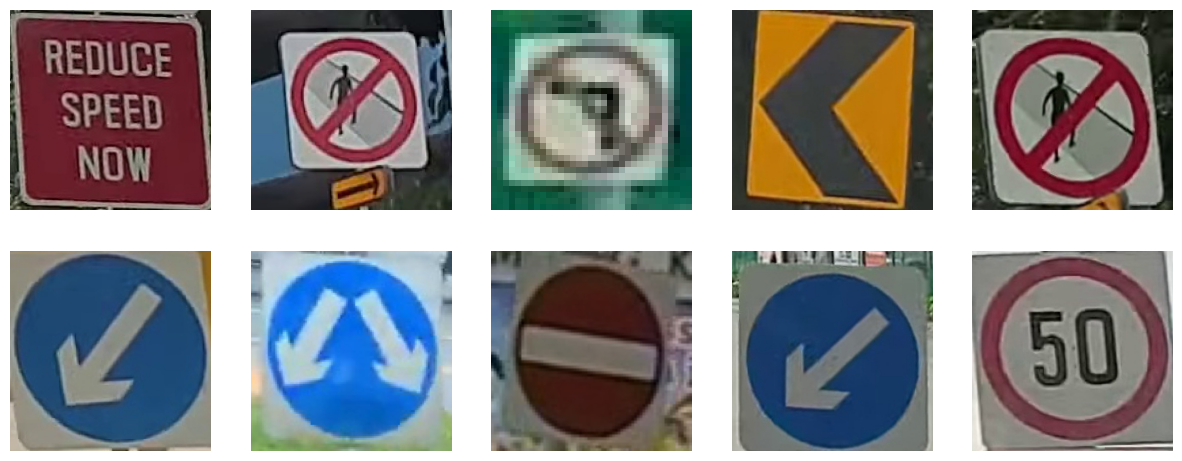

In [121]:
# Inspect sample train dataset
sample_train_df = train_df.sample(n=10)
ncols = 5
nrows = 4
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, traffic_sign_index in enumerate(sample_train_df.loc[:,'img_index']):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    plt.imshow(train_arr[traffic_sign_index])
    
plt.show()

As can be seen from the above sample of images from the train dataset, some of them are quite dark and some quite blurry. The images are taken at different time of the day and cropped to an aspect ratio of 1.0.

### Visualize training set distribution

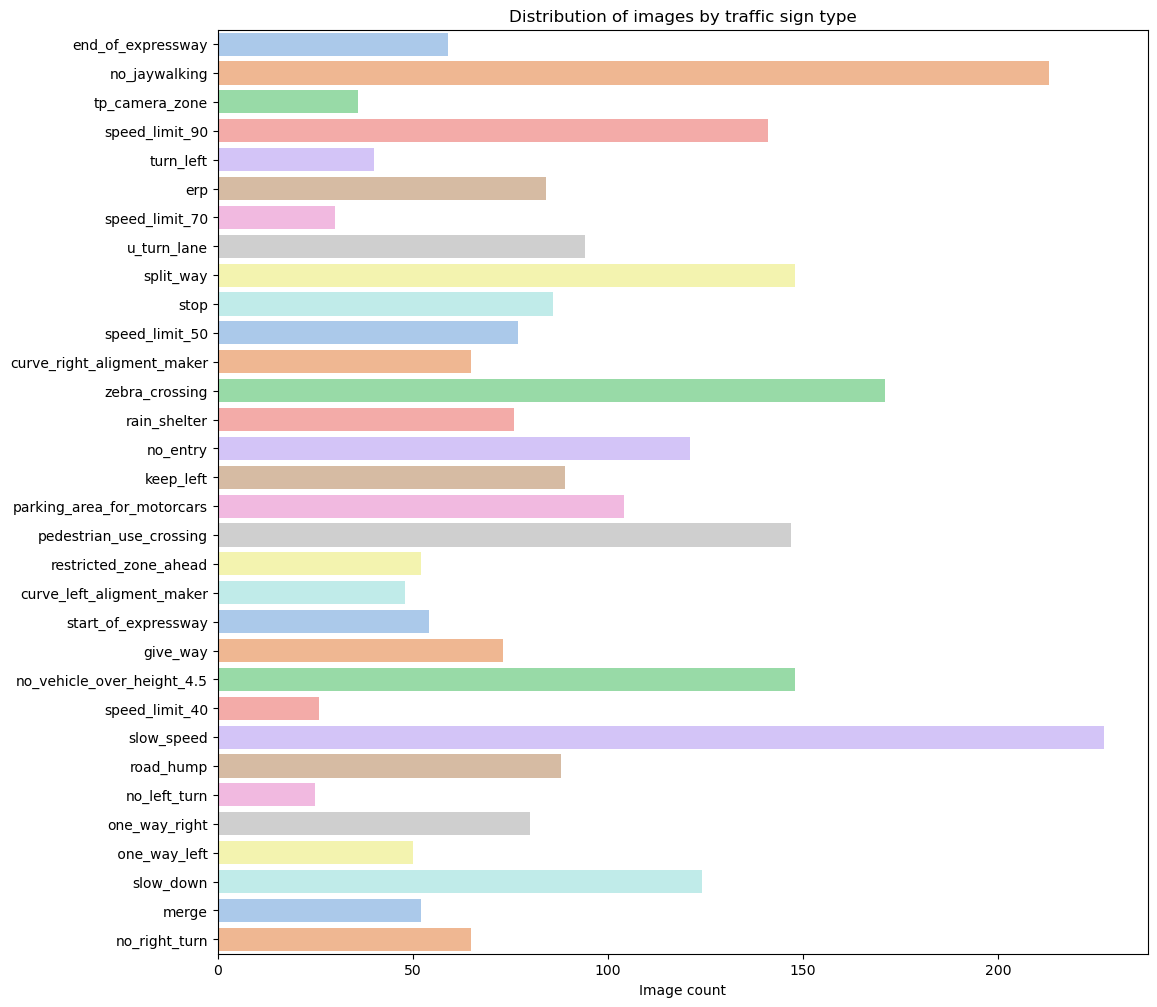

In [13]:
# Plot the distribution of the number of images for each class
plt.figure(figsize=(12,12))
sns.countplot(data=train_df, y='description', palette = "pastel")
plt.title('Distribution of images by traffic sign type')
plt.ylabel('')
plt.xlabel('Image count')
plt.show()

There is a significant imbalance across classes in the training set, as shown in the countplot above. Some classes have less than 40 images, while others have over 150. This means that our model could be biased towards over-represented classes, especially when it is unsure in its predictions. We will see later how we can mitigate this discrepancy using data augmentation.

### Inspect dimension variance

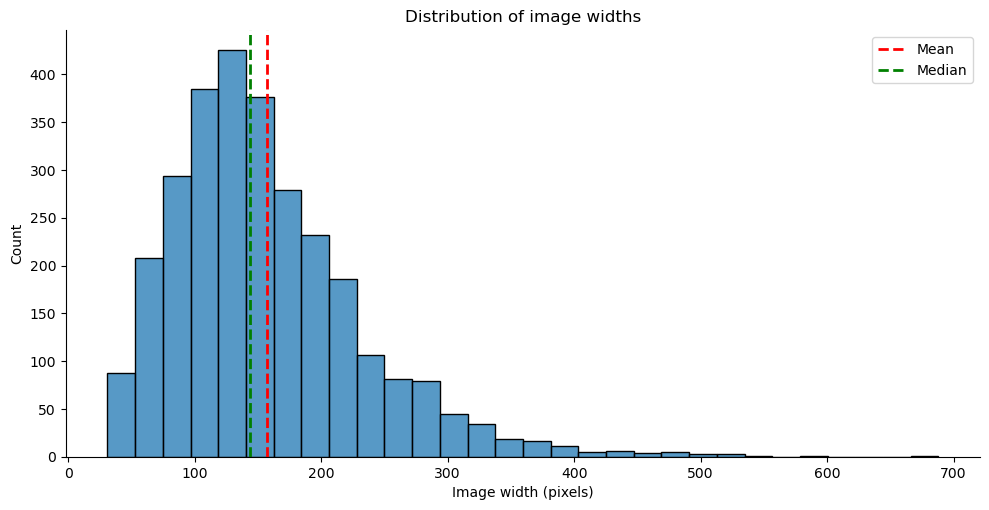

In [14]:
# Plot the distribution of image widths
sns.displot(data=train_df, x='img_width', height=5, aspect=2.0, bins=30)
plt.axvline(train_df.loc[:,'img_width'].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(train_df.loc[:,'img_width'].median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Distribution of image widths')
plt.xlabel('Image width (pixels)')
plt.legend()
plt.show()

Right skew observed for distribution of image widths, indicating a small proportion of traffic sign images with large width, up to nearly 700 pixels. Most images measure around 120-140 pixels as indicated by the mode, while mean width is approximately 157 pixels.

### Inspect image with largest width

In [15]:
largest_img = train_df.loc[train_df.loc[:,'img_width']==train_df.loc[:,'img_width'].max(),:]
largest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
613,432,7,u_turn_lane,../datasets/singapore_traffic_signs/train/7/39...,688,688,3,1.0,154.88175


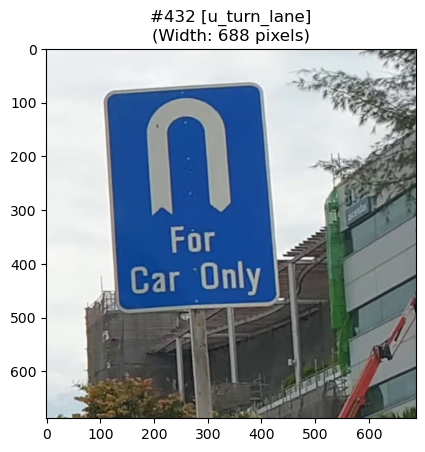

In [16]:
plt.imshow(train_arr[largest_img.iloc[0]['img_index']])
plt.title('#{} [{}]\n(Width: {} pixels)'.format(
    largest_img.iloc[0]['img_index'], 
    largest_img.iloc[0]['description'],
    largest_img.iloc[0]['img_width']
))
plt.show()

### Inspect image with smallest width

In [17]:
smallest_img = train_df.loc[train_df.loc[:,'img_width']==train_df.loc[:,'img_width'].min(),:]
smallest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
1437,2573,14,no_entry,../datasets/singapore_traffic_signs/train/14/1...,31,31,3,1.0,90.438906


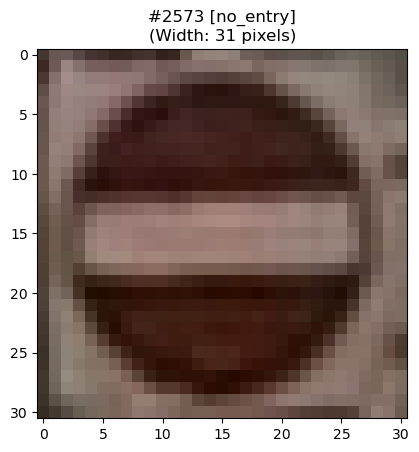

In [18]:
plt.imshow(train_arr[smallest_img.iloc[0]['img_index']])
plt.title('#{} [{}]\n(Width: {} pixels)'.format(
    smallest_img.iloc[0]['img_index'], 
    smallest_img.iloc[0]['description'],
    smallest_img.iloc[0]['img_width']
))
plt.show()

### Inspect brightest image

In [19]:
brightest_img = train_df.loc[ \
    train_df.loc[:,'img_brightness'] == train_df.loc[:,'img_brightness'].max(), : ]
brightest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
1810,57,18,restricted_zone_ahead,../datasets/singapore_traffic_signs/train/18/0...,66,62,3,1.064516,227.388711


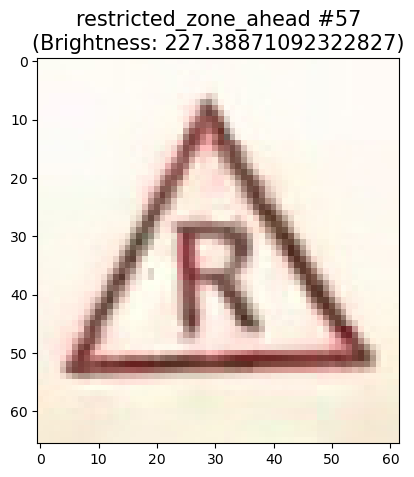

In [20]:
plt.figure(figsize=(5, 5))
plt.imshow(train_arr[brightest_img.iloc[0]['img_index']])
plt.title('{} #{}\n(Brightness: {})'.format(
    brightest_img.iloc[0]['description'], 
    brightest_img.iloc[0]['img_index'], 
    brightest_img.iloc[0]['img_brightness']), fontsize=15)
plt.show()

### Inspect darkest image

In [21]:
darkest_img = train_df.loc[ \
    train_df.loc[:,'img_brightness'] == train_df.loc[:,'img_brightness'].min(), : ]
darkest_img

,img_index,label,description,img_filename,img_height,img_width,img_channels,img_aspect_ratio,img_brightness
1053,347,11,curve_right_aligment_maker,../datasets/singapore_traffic_signs/train/11/1...,60,60,3,1.0,47.610628


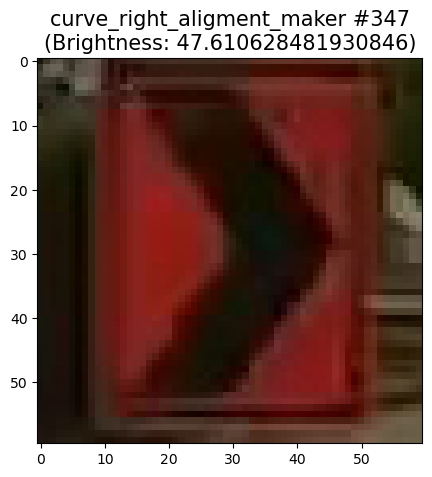

In [22]:
plt.figure(figsize=(5, 5))
plt.imshow(train_arr[darkest_img.iloc[0]['img_index']])
plt.title('{} #{}\n(Brightness: {})'.format(
    darkest_img.iloc[0]['description'], 
    darkest_img.iloc[0]['img_index'], 
    darkest_img.iloc[0]['img_brightness']), fontsize=15)
plt.show()

### Inspect test dataset

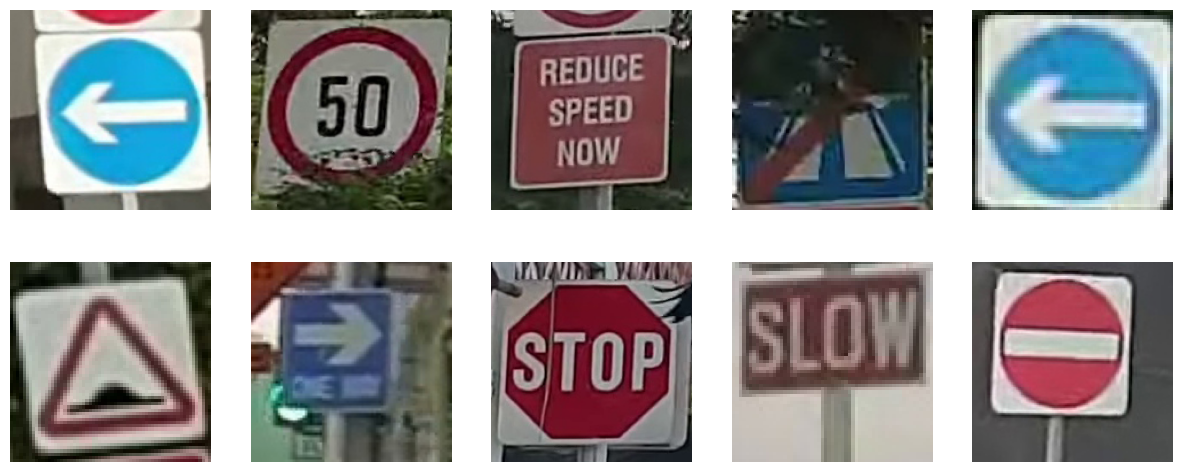

In [23]:
# Inspect test dataset
sample_test_df = test_df.sample(n=10)
ncols = 5
nrows = 2
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, traffic_sign_index in enumerate(sample_test_df.loc[:,'img_index']):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    plt.imshow(test_arr[traffic_sign_index])
    
plt.show()

Same as the train dataset, some of the test dataset's images are quite dark and some quite blurry, with more background noise and other artifacts (.e.g cropped at a side). This would provide a means to objectively evaluate the performance of the trained model. The evaluation would most likely yield an accuracy rating that is lower than the train and validation accuracy scores, though the extent of the gap in scores would give an indication of the model's ability to generalise.

## Preprocessing

### Checking for GPU

In [32]:
device_type = 'GPU'
physical_devices = tf.config.list_physical_devices(device_type) 
if physical_devices is not None:
    if len(physical_devices) > 0:
        print('Number of physical devices found: {}'.format(len(physical_devices)))
        print('Setting memory growth for 1st physical device: {}'.format(physical_devices[0].name))
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    else:
        print('No physical device of type [{}] found'.format(device_type))
else:
    print('No physical device of type [{}] found'.format(device_type))

No physical device of type [GPU] found


### Define training parameters

In [33]:
target_size = (50, 50) # image height, image width
batch_size = 128

### Data augmentation of train dataset using ImageDataGenerator

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.25,
                                   zoom_range=0.25,
                                   rotation_range=0.1,
                                   fill_mode='nearest',
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   validation_split=0.33) # set validation split

In [35]:
# Prepare training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=42)

Found 1954 images belonging to 32 classes.


In [36]:
# Prepare validation data
validation_generator = train_datagen.flow_from_directory(train_dir, # same directory as training data
                                                         target_size=target_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation',
                                                         seed=42)

Found 939 images belonging to 32 classes.


### Data augmentation of test dataset using ImageDataGenerator

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
# Prepare test data
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=target_size,
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 352 images belonging to 32 classes.


## Models Building and Selection

In [ ]:
# Functions for model evaluation
def plot_training_and_val_metrics(history, model, metric, train_color, val_colur):
    train_metric = history.history[metric]
    val_metric = history.history['val_{}'.format(metric)]
    # Set figure size
    plt.figure(figsize=(10, 6))
    plt.title('[{}] Training and Validation {} by Epoch'.format(model.name, str.capitalize(metric)), fontsize = 15)
    plt.plot(train_metric, label='Training {}'.format(str.capitalize(metric)), color=train_color)
    plt.plot(val_metric, label='Validation {}'.format(str.capitalize(metric)), color=val_colur)
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Categorical Crossentropy', fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    
def evaluate_model(model):
    print(f'Evaluation of {model.name}:\n')
    train_result = model.evaluate(train_generator, verbose=0)
    print(f'Train accuracy: {round(train_result[1]*100, 1)}%')
    validation_result = model.evaluate(validation_generator, verbose=0)
    print(f'Validation accuracy: {round(validation_result[1]*100, 1)}%')
    test_result = model.evaluate(test_generator, verbose=0)
    print(f'Test accuracy: {round(test_result[1]*100, 1)}%')

### Model 1

In [39]:
# Instantiate and define model
model_1 = Sequential([
    # 1st convo
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)),
    # flatten output to feed into a DNN
    Flatten(),
    # hidden layer
    Dense(units=32, activation='relu'),
    # output layer, where number of neurons is equal to number of classes expected, 
    # and softmax activation for categorical classification
    Dense(units=32, activation='softmax')
], name='model_1')

# Compile model
model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [40]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 32)                2359328   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
Total params: 2,361,280
Trainable params: 2,361,280
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Train model using 'rmsprop' optimizer
start = time.time()
model_1_history = model_1.fit(train_generator,
                              epochs=50,
                              validation_data=validation_generator,
                              verbose=1)
end = time.time()
print('Total training time: {}s'.format(end-start))

Epoch 1/50
16/16 [==============================] - 12s 687ms/step - loss: 3.7082 - acc: 0.1126 - val_loss: 2.8779 - val_acc: 0.1842
Epoch 2/50
16/16 [==============================] - 7s 459ms/step - loss: 2.7127 - acc: 0.1965 - val_loss: 2.6596 - val_acc: 0.1906
Epoch 3/50
16/16 [==============================] - 7s 469ms/step - loss: 2.3028 - acc: 0.3178 - val_loss: 2.2043 - val_acc: 0.4058
Epoch 4/50
16/16 [==============================] - 8s 478ms/step - loss: 1.8954 - acc: 0.4923 - val_loss: 1.7980 - val_acc: 0.5399
Epoch 5/50
16/16 [==============================] - 7s 464ms/step - loss: 1.5309 - acc: 0.5824 - val_loss: 1.6229 - val_acc: 0.5580
Epoch 6/50
16/16 [==============================] - 7s 459ms/step - loss: 1.2108 - acc: 0.6714 - val_loss: 1.4561 - val_acc: 0.6230
Epoch 7/50
16/16 [==============================] - 7s 461ms/step - loss: 0.9815 - acc: 0.7487 - val_loss: 1.0267 - val_acc: 0.7710
Epoch 8/50
16/16 [==============================] - 7s 458ms/step - loss: 0

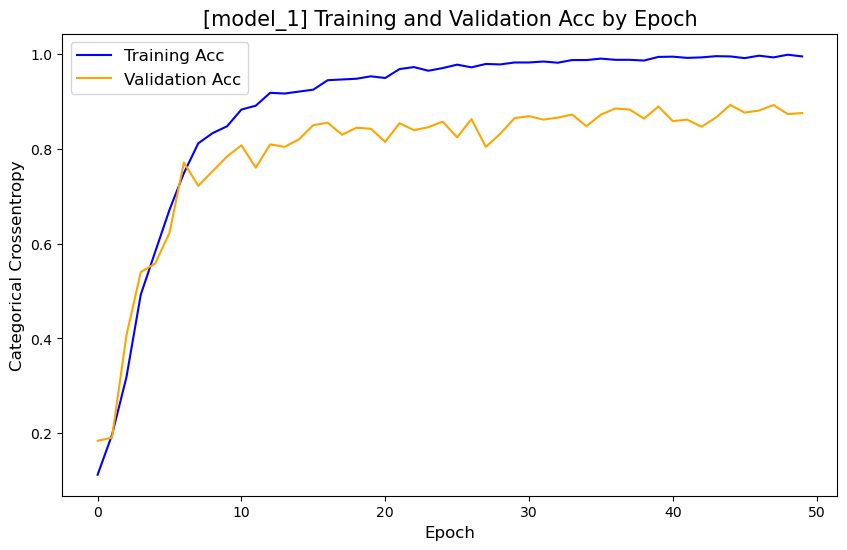

In [56]:
plot_training_and_val_metrics(model_1_history, model_1, 'acc', 'blue', 'orange')

At the 36th epoch, training accuracy score of 99% was attained while the validation accuracy score is 87%. In fact, validation accuracy stayed around that level and could not keep pace with training accuracy from the 8th epoch onwards, giving slight indication the model hit a limit on its ability to learn the underlying patterns that are required to differentiate between the traffic signs.

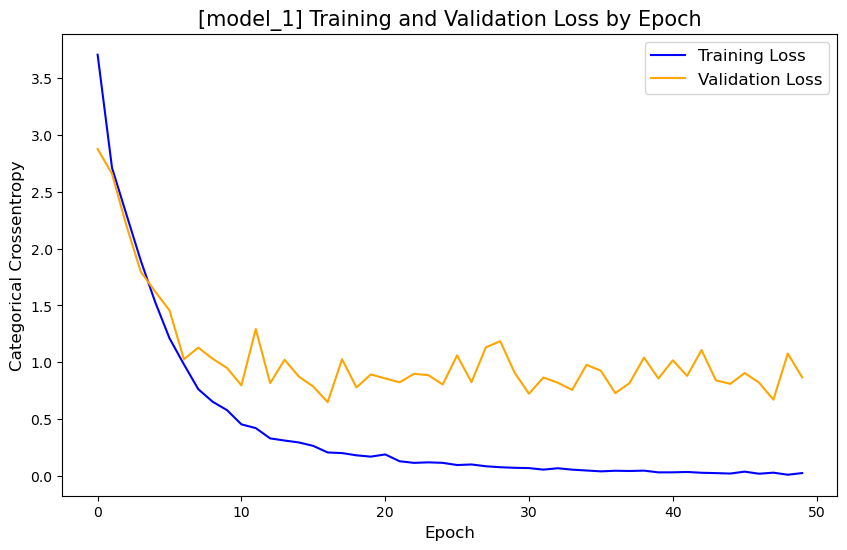

In [57]:
plot_training_and_val_metrics(model_1_history, model_1, 'loss', 'blue', 'orange')

Training loss was minimised to nearly 0, while validation loss remained at around 0.8 to 1.0 after the 30th epoch.

In [183]:
# Compute accuracy scores for train, validation and test datasets
evaluate_model(model_1)

Evaluation of model_1:

Train accuracy: 99.4%
Validation accuracy: 87.9%
Test accuracy: 60.8%


The evaluation result on test data shows that model_1 has performed poorly to cope with unseen data, as given by the accuracy score of 60.8%. 

### Model 2

In [61]:
# Instantiate and define model
model_2 = Sequential([
    # 1st convo
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    # 2nd convo
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # 3rd convo
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # 4th convo
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # flatten output to feed into a DNN
    Flatten(),
    # dense layer 1
    Dense(units=512, activation='relu'),
    # accompanying dropout
    Dropout(rate=0.5), #0.5
    # dense layer 2
    Dense(units=256, activation='relu'),
    # accompanying dropout
    Dropout(rate=0.5), #0.5
    # dense layer 3
    Dense(units=128, activation='relu'),
    # accompanying dropout
    Dropout(rate=0.5), #0.5
    # output dense layer with softmax activation for categorical classification
    Dense(units=32, activation='softmax')
], name='model_2')

# Compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

In [62]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 128)       18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0   

In [63]:
# Define early stopping
early_stop_callback = EarlyStopping(monitor='loss', patience=5)

In [64]:
# Train model_2
start = time.time()
model_2_history = model_2.fit(train_generator,
                              epochs=50,
                              validation_data=validation_generator,
                              callbacks=[early_stop_callback],
                              verbose=1)
end = time.time()
print('Total training time: {}s'.format(end-start))

Epoch 1/50
16/16 [==============================] - 13s 753ms/step - loss: 3.4832 - accuracy: 0.0594 - val_loss: 3.3315 - val_accuracy: 0.0745
Epoch 2/50
16/16 [==============================] - 10s 627ms/step - loss: 3.3605 - accuracy: 0.0711 - val_loss: 3.3784 - val_accuracy: 0.1864
Epoch 3/50
16/16 [==============================] - 10s 644ms/step - loss: 3.3281 - accuracy: 0.0844 - val_loss: 3.1167 - val_accuracy: 0.1310
Epoch 4/50
16/16 [==============================] - 11s 679ms/step - loss: 3.1097 - accuracy: 0.1290 - val_loss: 2.8787 - val_accuracy: 0.1395
Epoch 5/50
16/16 [==============================] - 11s 655ms/step - loss: 3.0074 - accuracy: 0.1228 - val_loss: 2.7601 - val_accuracy: 0.1406
Epoch 6/50
16/16 [==============================] - 12s 736ms/step - loss: 2.8473 - accuracy: 0.1602 - val_loss: 2.8439 - val_accuracy: 0.1651
Epoch 7/50
16/16 [==============================] - 12s 734ms/step - loss: 2.6191 - accuracy: 0.2078 - val_loss: 2.2696 - val_accuracy: 0.2556

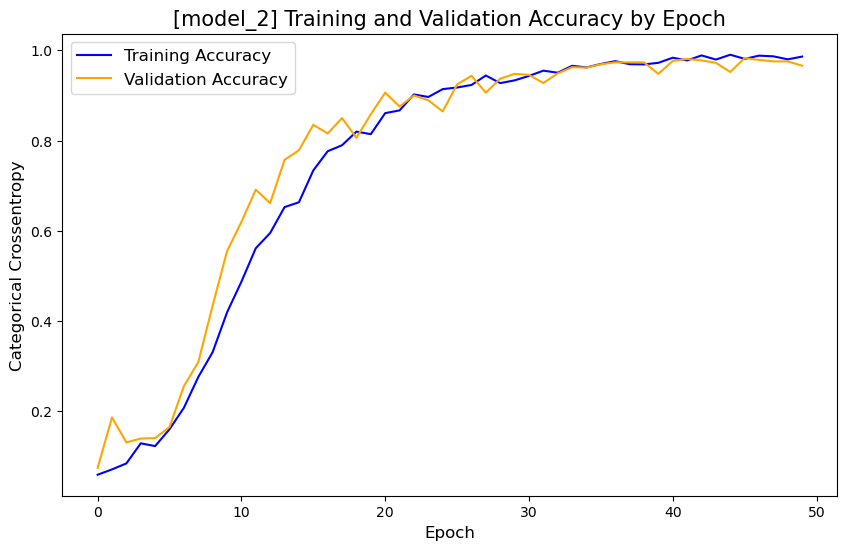

In [65]:
plot_training_and_val_metrics(model_2_history, model_2, 'accuracy', 'blue', 'orange')

At the 41 epoch, training accuracy came to 98%, while validation accuracy was 97%. As observed, validation accuracy was able to keep pace with the training accuracy throughout the training process.

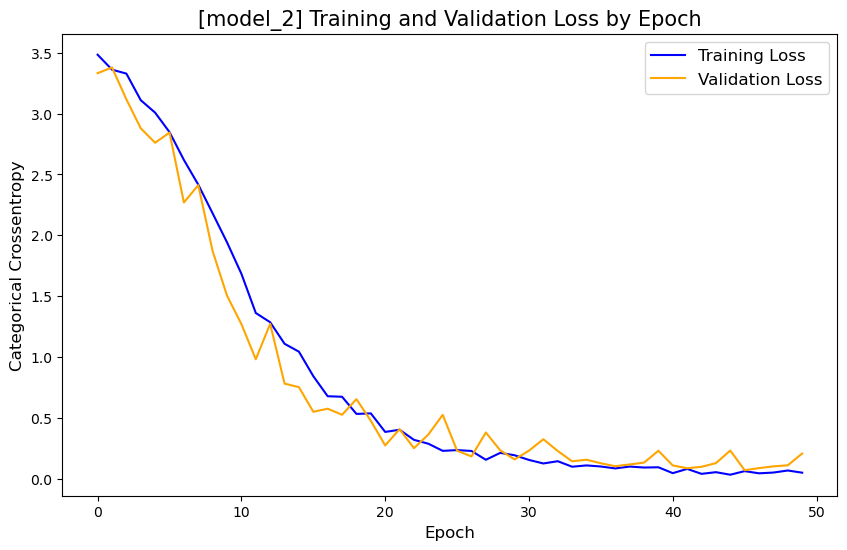

In [66]:
plot_training_and_val_metrics(model_2_history, model_2, 'loss', 'blue', 'orange')

Both training and validation loss reached nearly 0 at the end of the training process. More importantly, validation loss was able to keep pace with training loss.

In [184]:
# Compute accuracy scores for train, validation and test datasets
evaluate_model(model_2)

Evaluation of model_2:

Train accuracy: 99.6%
Validation accuracy: 96.3%
Test accuracy: 90.1%


The evaluation result on test data shows that model_2 has achieved a test accuracy of 90.1%. This is a great improvement as compared to model_1, and indicates that it is able to generalize to unseen data to a much better extent.

### VGG19

### Data augmentation of datasets using ImageDataGenerator

In [72]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='sparse',
                                                subset='training',
                                                seed=42)  # set as training data
validation_set = train_datagen.flow_from_directory(train_dir, # same directory as training data
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    seed=42) # set as validation data
test_set = test_datagen.flow_from_directory(test_dir, 
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='sparse')

Found 1954 images belonging to 32 classes.
Found 939 images belonging to 32 classes.
Found 352 images belonging to 32 classes.


In [225]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 5s 0us/step


In [226]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [227]:
x = Flatten()(vgg.output)

In [228]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(32, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [229]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [230]:
# compile the model 
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

#model.compile(optimizer=RMSprop(0.001), loss='categorical_crossentropy',metrics=['accuracy'])

In [231]:
# Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [233]:
# fit the model
start = time.time()
vgg19_history = model.fit(
                training_set,
                validation_data=validation_set,
                epochs=10,
                callbacks=[early_stop],
                batch_size=32,
                shuffle=True,
                verbose=1)
end = time.time()
print('Total training time: {}s'.format(end-start))

Epoch 1/10
62/62 [==============================] - 3481s 57s/step - loss: 0.9878 - accuracy: 0.7863 - val_loss: 0.6790 - val_accuracy: 0.8179
Epoch 2/10
62/62 [==============================] - 3321s 54s/step - loss: 0.0633 - accuracy: 0.9852 - val_loss: 0.3748 - val_accuracy: 0.9063
Epoch 3/10
62/62 [==============================] - 2483s 40s/step - loss: 0.0203 - accuracy: 0.9964 - val_loss: 0.3717 - val_accuracy: 0.8829
Epoch 4/10
62/62 [==============================] - 2180s 35s/step - loss: 0.0148 - accuracy: 0.9969 - val_loss: 0.4781 - val_accuracy: 0.8754
Epoch 5/10
62/62 [==============================] - 2712s 44s/step - loss: 0.0163 - accuracy: 0.9969 - val_loss: 0.3648 - val_accuracy: 0.8914
Epoch 6/10
62/62 [==============================] - 4501s 73s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.3351 - val_accuracy: 0.9063
Epoch 7/10
62/62 [==============================] - 2673s 43s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2722 - val_accuracy: 0.9212

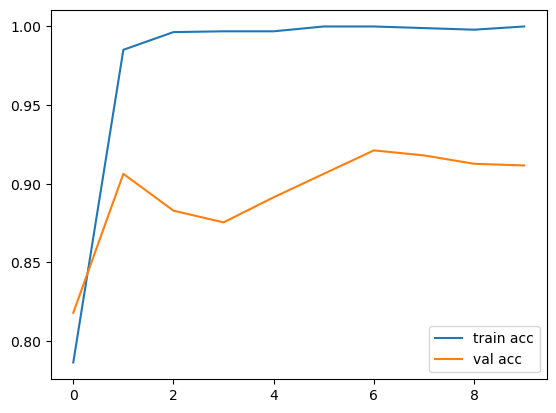

In [242]:
# accuracies
plt.plot(vgg19_history.history['accuracy'], label='train acc')
plt.plot(vgg19_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

Training accuracy score of 100% was attained as early as 6th epoch,  while the validation accuracy score was 90%. In fact, validation accuracy stayed around that level and could not keep pace with training accuracy from the 2nd epoch onwards.

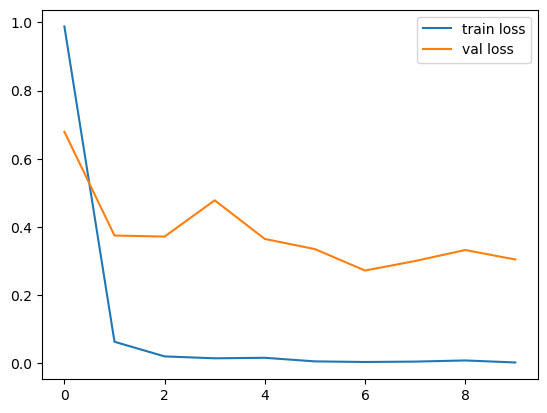

In [244]:
# loss
plt.plot(vgg19_history.history['loss'], label='train loss')
plt.plot(vgg19_history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

Training loss was minimised to nearly 0, while validation loss remained at around 0.3 to 0.5 after the 2nd epoch.

In [247]:
evaluate_model(model)

Evaluation of model_1:

     Train accuracy: 100.0%
Validation accuracy: 90.4%
      Test accuracy: 87.8%


The evaluation result on test data shows that vgg19 model has achieved a test accuracy of 87.8%. 

|Model|Train accuracy|Val accuracy|Test accuracy|Runtime|
|---|---|---|---|---|
|CNN Model_1|99.4%|87.9%|60.8%|396.92s|
|CNN Model_2|99.6%|96.3%|90.1%|930.41s|
|VGG19|100%|90.4%|87.8%|27489.49s|

After analysis of all the models performance and time required for the training process, CNN Model_2 will be chosen as my final model used for predicting on the unseen test dataset.

The CNN Model_1 has the poorest generalisation among the three models. Although the VGG19 model has the highest training accuracy, its generalisation paled in comparison to CNN Model_2. Moreover, VGG19 is taking way much longer to train than the other two models. On the other hand, CNN Model_2 has the highest validation of 96.3% and test accuracy 90.1%. So, we can conclude that CNN Model_2 is doing a fairly good job in predicting the classes of traffic signs.

### Save model

In [69]:
# Save the trained model_2
Pkl_Filename = '../classification_model/Pickle_CNN_Model_2.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_2, file)

INFO:tensorflow:Assets written to: ram://45cffc6f-77b9-4afe-823e-788593afc7fe/assets


INFO:tensorflow:Assets written to: ram://45cffc6f-77b9-4afe-823e-788593afc7fe/assets


In [185]:
# Load and test model_2
with open(Pkl_Filename, 'rb') as file:  
    test_loaded_model = pickle.load(file)

evaluate_model(test_loaded_model)

Evaluation of model_2:

Train accuracy: 99.5%
Validation accuracy: 96.8%
Test accuracy: 90.1%


## Results Analysis and Conclusion

In [41]:
# Load model_2
Pkl_Filename = '../classification_model/Pickle_CNN_Model_2.pkl'  
with open(Pkl_Filename, 'rb') as file:  
    pred_model_2 = pickle.load(file)

In [42]:
# Prepare test data
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(50, 50),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 352 images belonging to 32 classes.


In [43]:
# Get list of images from test_datagen
image_list = []
num_pics = len(test_generator.classes)
test_datagen_img = test_generator.next()
while len(image_list) < num_pics:
    image_list.append(test_datagen_img[0])
    test_datagen_img = test_generator.next()
print(len(image_list))

352


In [44]:
# Reset test generator
test_generator.reset()

In [45]:
# Predict test dataset in probabilty
predictions = pred_model_2.predict_generator(test_generator)

/var/folders/_s/2k6c2y293tl37khbd17nwl100000gn/T/ipykernel_46619/4213308111.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = pred_model_2.predict_generator(test_generator)


In [46]:
# Convert predictions to class number
predicted_class_indices=np.argmax(predictions,axis=1)

In [48]:
predicted_class_indices

array([ 0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  1,  1,  1,  1,  1,  1, 15,
        1,  1,  1,  1, 23,  2,  2,  2,  2,  2,  2, 28,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 11,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4, 30,  5,  5, 29,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8, 30,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 29, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
       13,  7, 13, 29, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15,
       15,  5, 15, 15, 15, 15, 15, 15, 15, 15, 10,  2, 16, 16, 16, 16, 16,
       16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 28, 27, 18,
       27, 18, 24, 18, 18, 18, 18, 19, 19, 19, 30, 19, 19, 20, 20, 20, 29,
       20, 20, 20, 20, 20

In [49]:
# Extract name of classes
label_to_class = {v: class_label.loc[k,'description'] for k,v in test_generator.class_indices.items()}
label_to_desc = [label_to_class[k] for k in sorted(label_to_class.keys())]
predictions = [label_to_class[k] for k in predicted_class_indices]

In [50]:
predictions

['end_of_expressway',
 'end_of_expressway',
 'end_of_expressway',
 'end_of_expressway',
 'end_of_expressway',
 'end_of_expressway',
 'end_of_expressway',
 'split_way',
 'end_of_expressway',
 'end_of_expressway',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'no_vehicle_over_height_4.5',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'no_jaywalking',
 'speed_limit_90',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_70',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'speed_limit_50',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_right_aligment_maker',
 'curve_left_aligmen

In [51]:
# create dataframe with image label and predicted class
results = pd.DataFrame({'label': test_generator.classes, 'prediction':predictions})
results.loc[:,'label'] = results.loc[:,'label'].apply(lambda x: label_to_class[x])
results.loc[:,'img_index'] = results.index
results = results.loc[:,['img_index','label','prediction']]

In [52]:
results.head()

,img_index,label,prediction
0,0,end_of_expressway,end_of_expressway
1,1,end_of_expressway,end_of_expressway
2,2,end_of_expressway,end_of_expressway
3,3,end_of_expressway,end_of_expressway
4,4,end_of_expressway,end_of_expressway


In [53]:
# Sample of 10 correct predictions
correct_predictions = results.loc[results.loc[:,'label'] == results.loc[:,'prediction'],:]
print(f'Images correctly predicted:',correct_predictions.value_counts().sum())
correct_predictions.sample(10)

Images correctly predicted: 317


,img_index,label,prediction
313,313,u_turn_lane,u_turn_lane
66,66,rain_shelter,rain_shelter
294,294,erp,erp
260,260,speed_limit_90,speed_limit_90
254,254,speed_limit_90,speed_limit_90
80,80,no_entry,no_entry
283,283,no_right_turn,no_right_turn
172,172,no_vehicle_over_height_4.5,no_vehicle_over_height_4.5
153,153,start_of_expressway,start_of_expressway
29,29,speed_limit_50,speed_limit_50


In [54]:
# Sample of 10 incorrect predictions
incorrect_predictions = results.loc[results.loc[:,'label'] != results.loc[:,'prediction'],:]
print(f'Images incorrectly predicted:',incorrect_predictions.value_counts().sum())
incorrect_predictions.sample(10)

Images incorrectly predicted: 35


,img_index,label,prediction
239,239,slow_down,stop
58,58,zebra_crossing,split_way
263,263,merge,end_of_expressway
250,250,speed_limit_90,u_turn_lane
262,262,merge,u_turn_lane
206,206,road_hump,merge
234,234,one_way_left,u_turn_lane
349,349,stop,split_way
316,316,u_turn_lane,split_way
289,289,turn_left,keep_left


In [102]:
# Function to show image prediction and print probability
def show_image_probs(image_index):
    img_pred = pred_model_2.predict(image_list[image_index])
    img_pred_proba_df = pd.DataFrame({'label': label_to_desc, 'pred_proba': img_pred[0]})
    sns.set(style="whitegrid", color_codes=True)
    pal = sns.color_palette("YlOrBr_r", len(img_pred_proba_df['pred_proba']))
    rank = img_pred_proba_df['pred_proba'].argsort().argsort()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image_list[image_index][0])
    print(f'Image index: {image_index}')
    print(f'      Label: {results.loc[results.loc[:,"img_index"]==image_index, "label"].values[0]}')
    print(f' Prediction: {results.loc[results.loc[:,"img_index"]==image_index, "prediction"].values[0]}')
    
    plt.subplot(122)
    plt.title('Prediction Probabilities by Traffic Sign Class', fontsize=15)
    sns.barplot(data=img_pred_proba_df, x='pred_proba', y='label', palette=np.array(pal[::-1])[rank])
    plt.ylabel('')
    plt.tick_params(axis='y', which='major', labelsize=8)
    plt.xlabel('Prediction Probability')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

1/1 [==============================] - 0s 40ms/step
Image index: 306
      Label: speed_limit_70
 Prediction: speed_limit_70


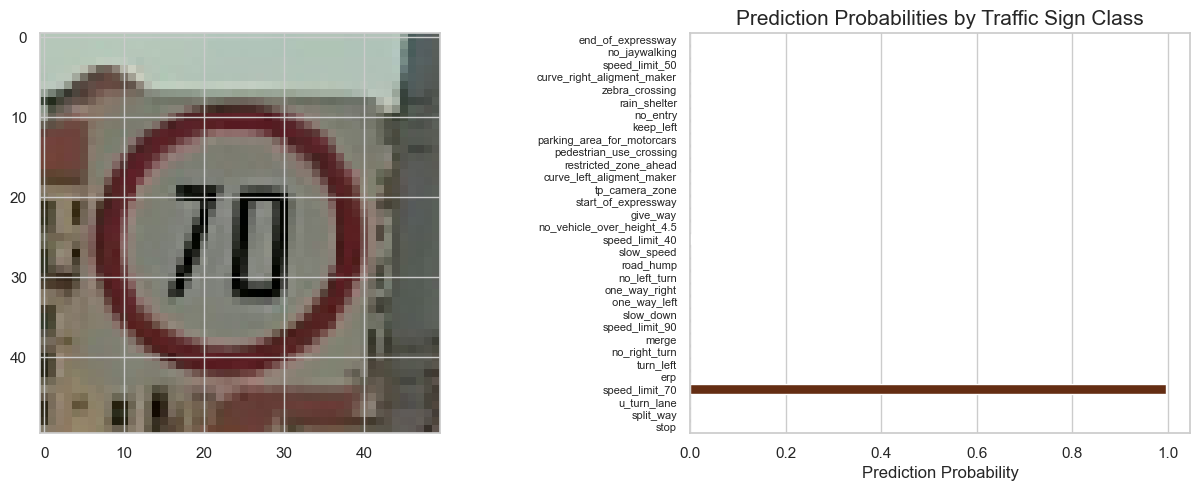

In [103]:
# Show image and probability of correct prediction
show_image_probs(correct_predictions.loc[306,'img_index'])

1/1 [==============================] - 0s 25ms/step
Image index: 116
      Label: pedestrian_use_crossing
 Prediction: pedestrian_use_crossing


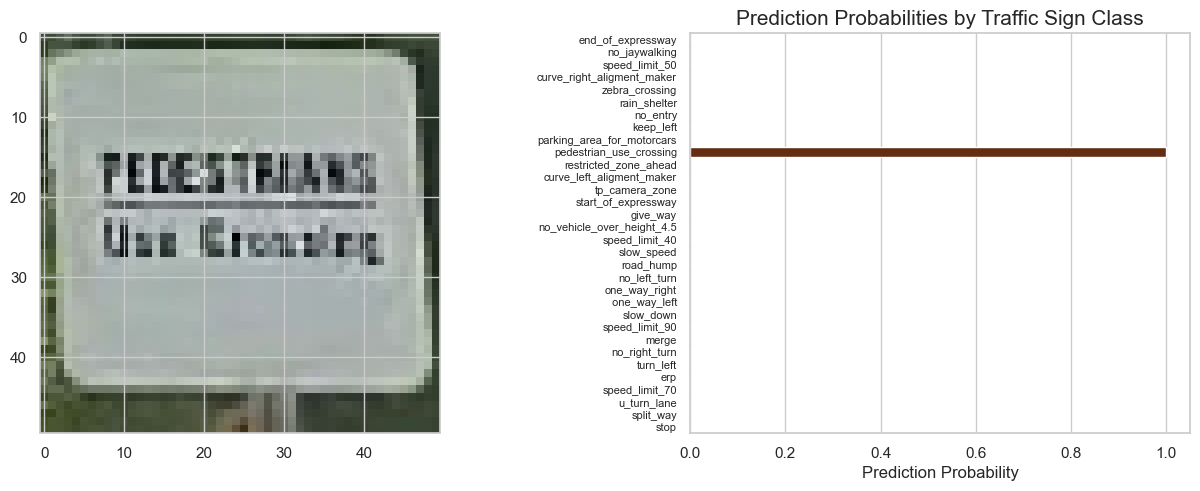

In [104]:
# Show image and probability of correct prediction
show_image_probs(correct_predictions.loc[116,'img_index'])

1/1 [==============================] - 0s 27ms/step
Image index: 16
      Label: no_jaywalking
 Prediction: no_vehicle_over_height_4.5


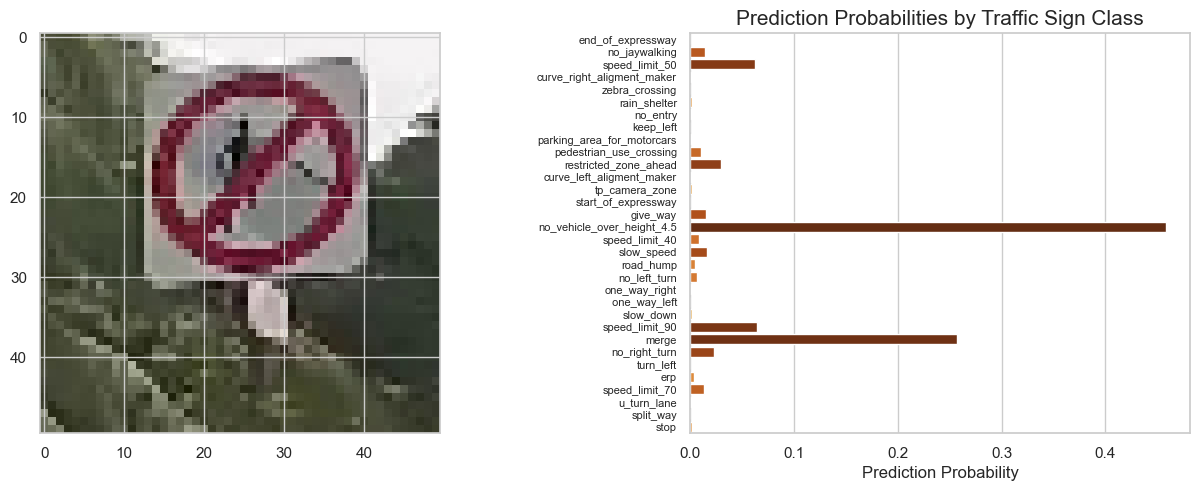

In [105]:
# Show image and probability of incorrect prediction
show_image_probs(incorrect_predictions.loc[16,'img_index'])

1/1 [==============================] - 0s 39ms/step
Image index: 61
      Label: rain_shelter
 Prediction: u_turn_lane


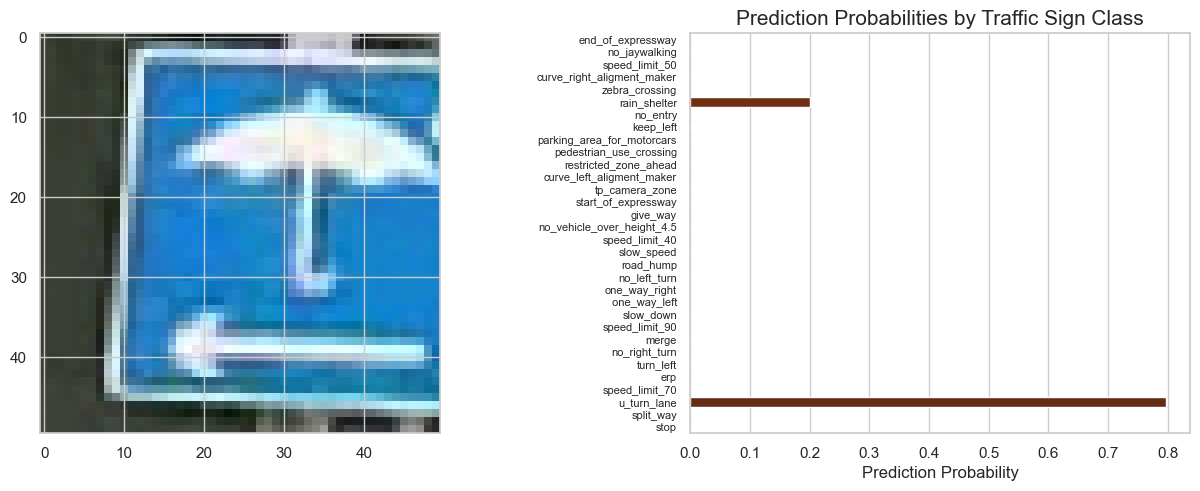

In [106]:
# Show image and probability of incorrect prediction
# Show image and probability of incorrect prediction
show_image_probs(incorrect_predictions.loc[61,'img_index'])

### Confusion Matrix

In [ ]:
# Reset test generator
test_generator.reset()

In [60]:
all_test_labels = test_df['description']
all_test_labels

0      end_of_expressway
1      end_of_expressway
2      end_of_expressway
3      end_of_expressway
4      end_of_expressway
             ...        
347        no_right_turn
348        no_right_turn
349        no_right_turn
350        no_right_turn
351        no_right_turn
Name: description, Length: 352, dtype: object

In [70]:
# Prepare parameters for confusion matrix
y_pred = predicted_class_indices
y_target = test_generator.classes
labels = all_test_labels.unique()
cm = confusion_matrix(y_target, y_pred)

In [71]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=28)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)
    plt.show()

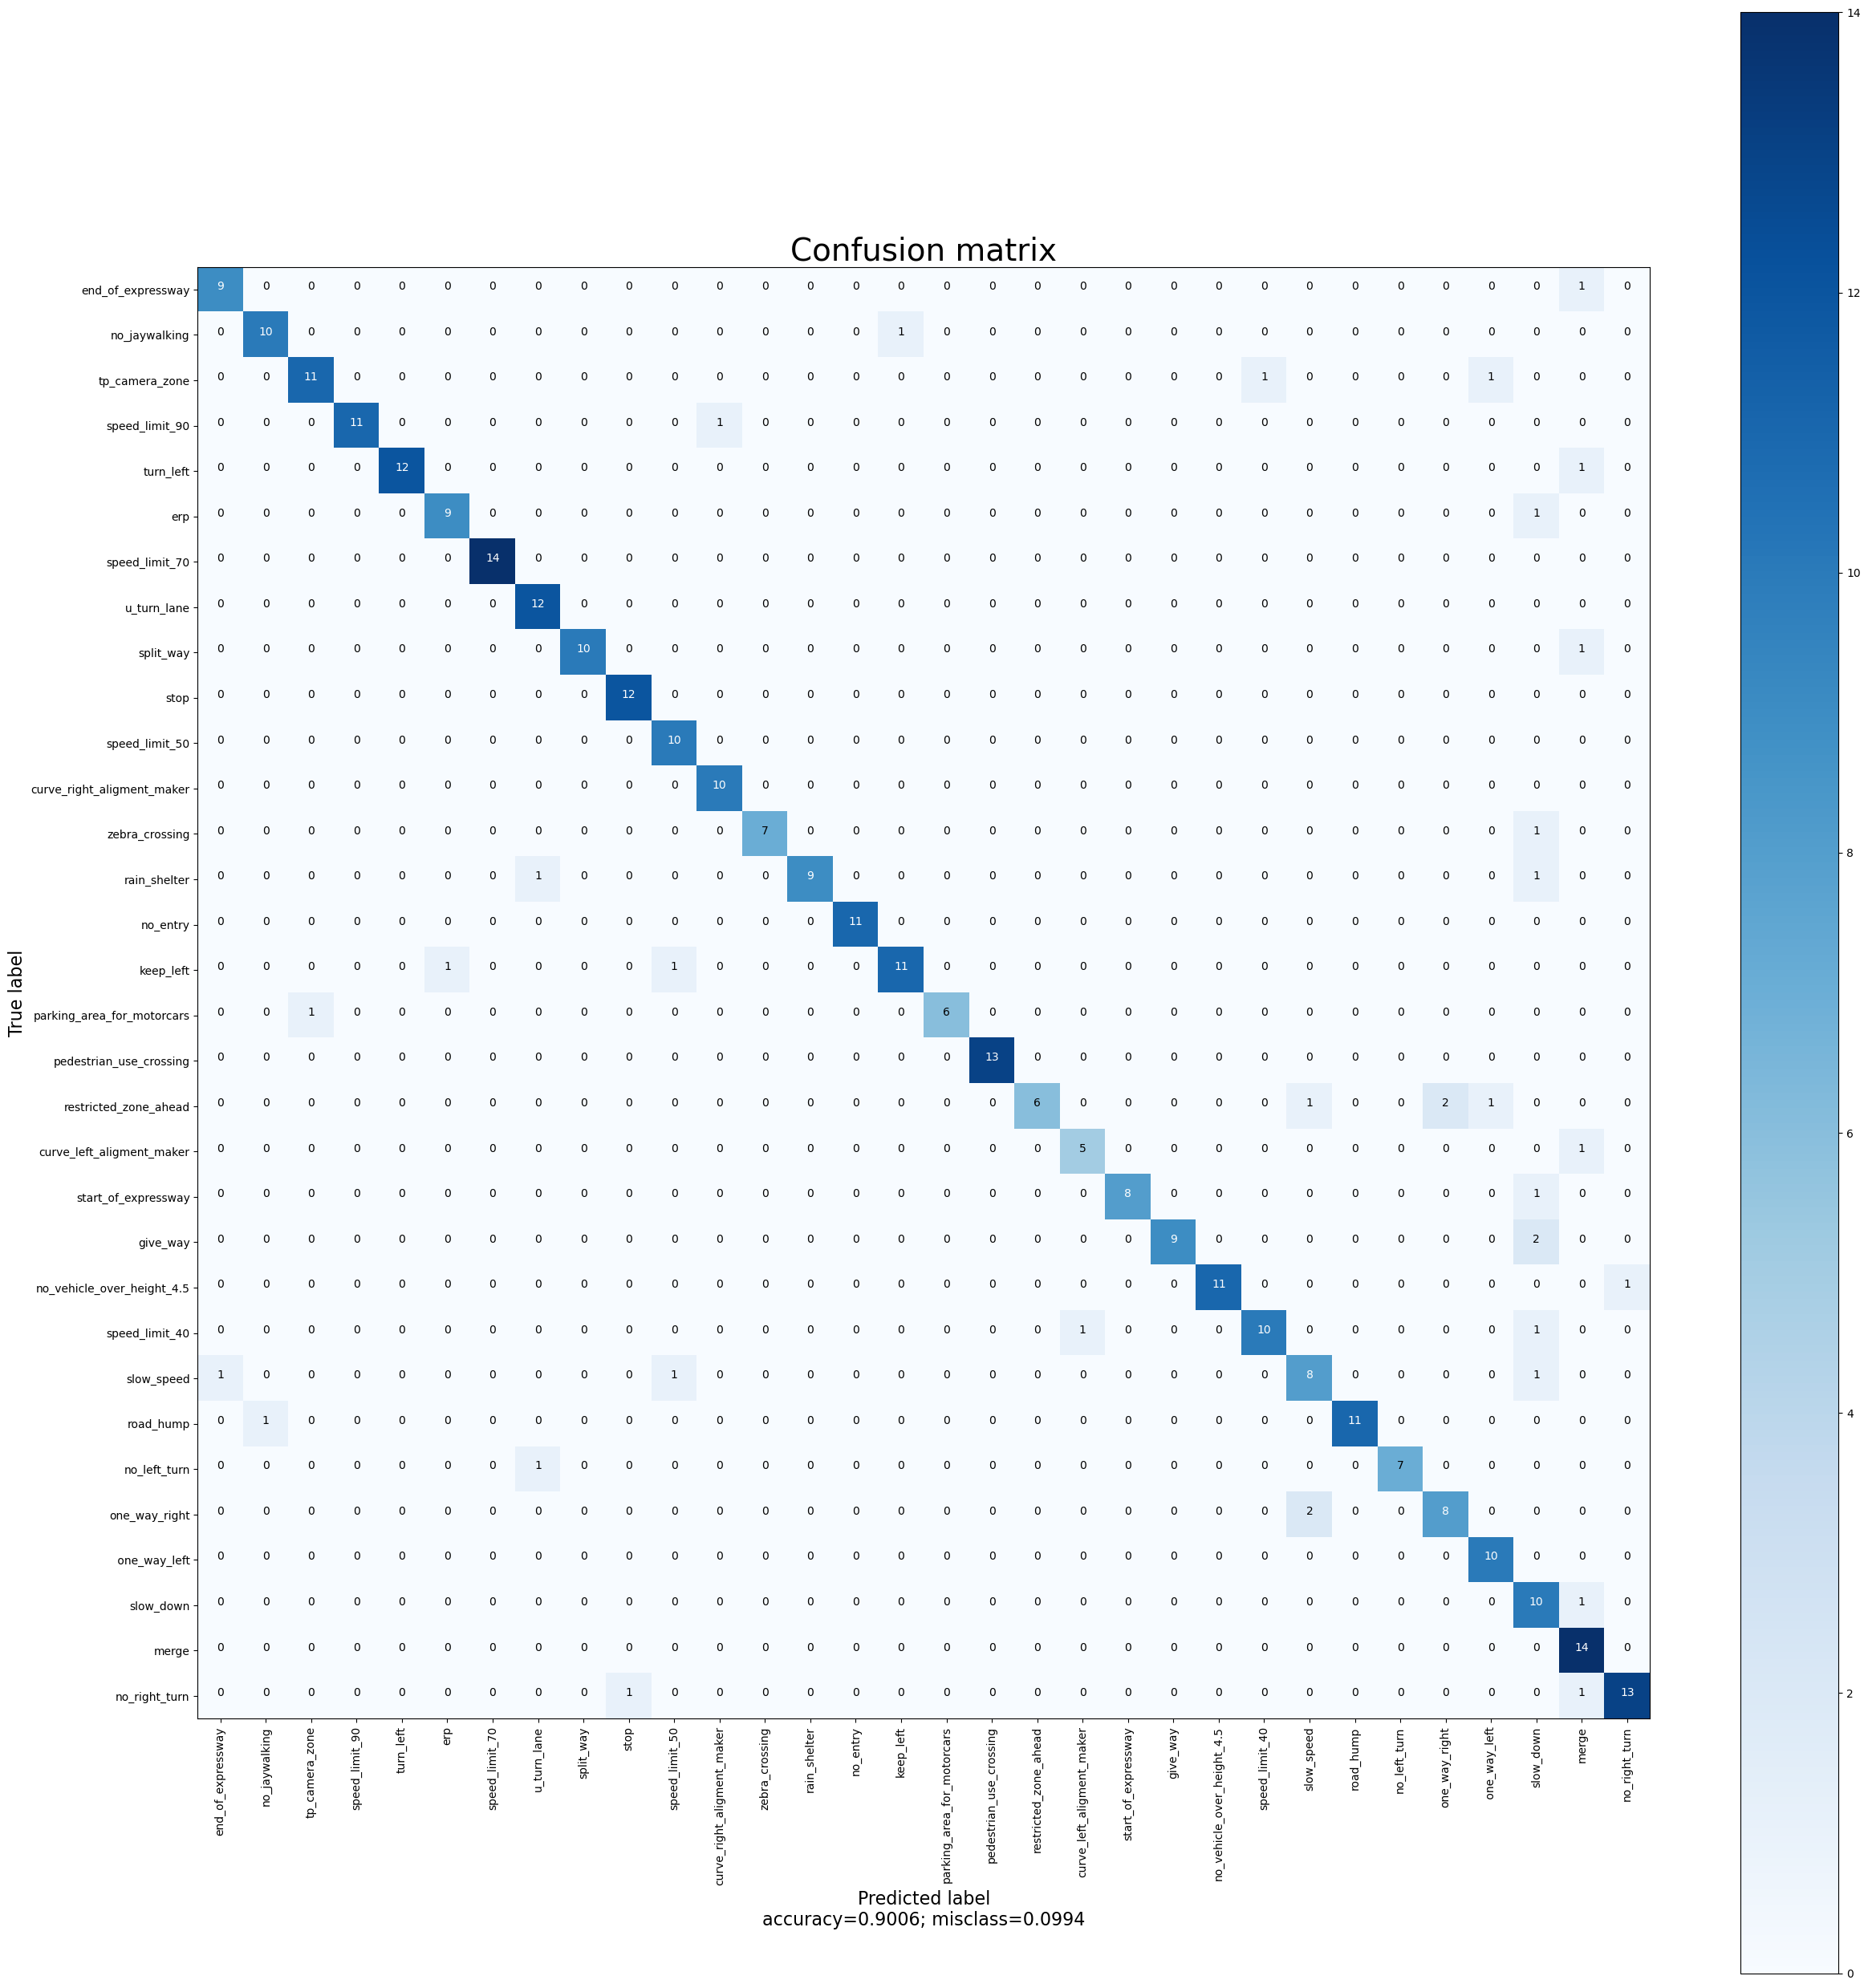

In [72]:
plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False)

In [74]:
# Classification Report
print('Classification Report')
target_names = labels
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                            precision    recall  f1-score   support

         end_of_expressway       0.90      0.90      0.90        10
             no_jaywalking       0.91      0.91      0.91        11
            tp_camera_zone       0.92      0.85      0.88        13
            speed_limit_90       1.00      0.92      0.96        12
                 turn_left       1.00      0.92      0.96        13
                       erp       0.90      0.90      0.90        10
            speed_limit_70       1.00      1.00      1.00        14
               u_turn_lane       0.86      1.00      0.92        12
                 split_way       1.00      0.91      0.95        11
                      stop       0.92      1.00      0.96        12
            speed_limit_50       0.83      1.00      0.91        10
curve_right_aligment_maker       0.91      1.00      0.95        10
            zebra_crossing       1.00      0.88      0.93         8
              rain_shelte

We can see that the model_2 has achieved an accuracy score of 90%. In the pre-processing phase, we use the image data-generator features of Tensorflow to perform data augmentation, as well as train/validation split. A test set,  containing more background clutter and other variances, was  used to evaluate our trained model on unseen images. 

Model_1 was a basic convolutional neural network consisting of 1 Conv2D layer with 32 filters, connected to dense hidden layer of 32 units, then followed by output dense layer of 32 units to reflect the categorical classification of the 32 classes. Even though the training accuracy achieved 99.4%, it's test accuracy was only 60.8%, suggesting that insufficient network capacity was more of an issue than overfitting.

Model_2 was a more fully connected network with 4 Conv2D and max-pooling layers to down-sample the feature map outputs from respective convolutional layers. This is followed by 3 more hidden dense layers with accompanying dropout layers as a form of regularisation to mitigate our model from overfitting. Early stop criteria was set to monitor training loss for stagnant over 5 epoch, but was never triggered. Lastly all 3 accuracy metrics are well within 10% deviation of each other.

The 3rd model, which is a VGG-19 pre-trained model, comprises of 5 Conv2D and max-pooling layers followed by output dense layer of 32 units. Early stop criteria was also set to monitor training loss for stagnant over 5 epoch, but was never triggered. Even though the training accuracy achieved 100%, it's validation and test accuracy was only 90.4% and 87.8% respectively, suggesting that more training passes might improve the model's performance.

Out of the 352 images of traffic signs, all of them have been successfully classified except for 35 images which has been miss-classified. This results substantiate that the model has successfully classified around 90% of all the images. Therefore, it can be concluded that the model predicts all 32 classes quite well although not perfectly.

Recommendations



- To include more training images of traffic signs that are not so tightly cropped. 
- To expand the dataset further, as Singapore has a total of more than 80 classes of traffic signs. 
- To have the models run more epochs if time is not a constraint